<a href="https://colab.research.google.com/github/T-Naveen-2308/IIITH-FMML-Assignments/blob/main/Week_5_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
rng = np.random.default_rng(seed=42)

(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X / 255
test_X = test_X / 255

train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let us borrow a few functions from the previous labs:

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [14]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_X.reshape(-1, 28*28), train_y)
test_pred = knn.predict(test_X.reshape(-1, 28*28))
print("Baseline accuracy without augmentation:", accuracy_score(test_y, test_pred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

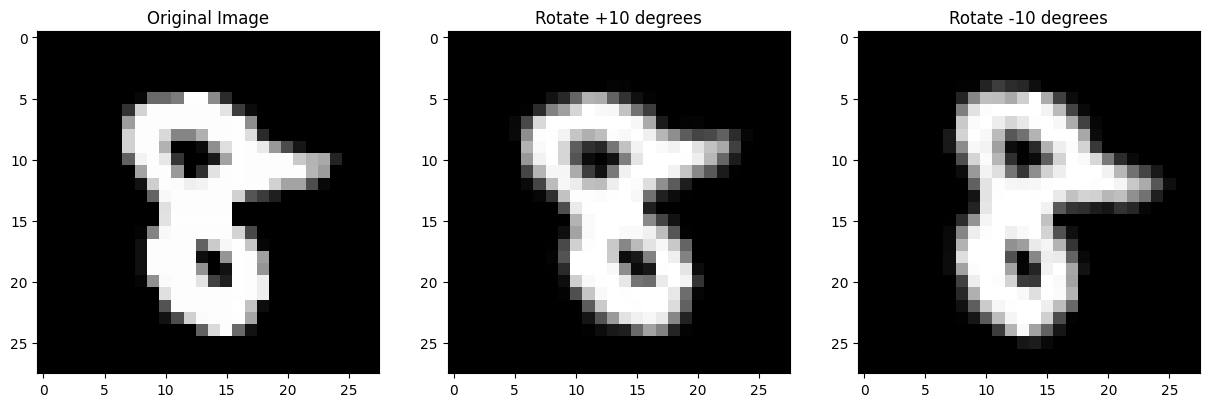

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [18]:
def aug_rotate(sample, angle_constraint):
    if angle_constraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))
    angle = (angle - 0.5) * angle_constraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

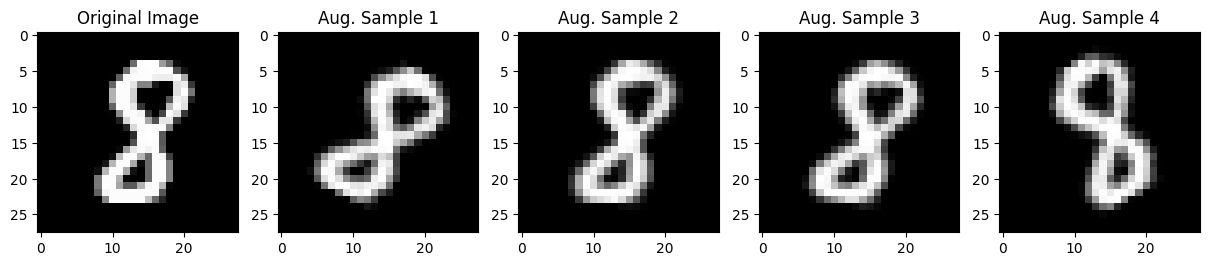

In [20]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(aug_rotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(aug_rotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(aug_rotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(aug_rotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [28]:
angle_constraint = 60
n_augmentations = 5

aug_data = train_X
aug_target = train_y
for ii in range(n_augmentations):
    aug_data = np.concatenate((aug_data, aug_rotate(train_X, angle_constraint)))
    aug_target = np.concatenate((aug_target, train_y))

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(aug_data.reshape(-1, 28*28), aug_target)
testpred = knn.predict(test_X.reshape(-1, 28*28))
print("Accuracy after rotation augmentation:", accuracy_score(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 63.61 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [26]:
angle_constraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
accuracies = np.zeros(len(angle_constraints), dtype=float)

for ii in range(len(angle_constraints)):
    aug_data = train_X
    aug_target = train_y
    for jj in range(n_augmentations):
        aug_data = np.concatenate((aug_data, aug_rotate(train_X, angle_constraints[ii])))
        aug_target = np.concatenate((aug_target, train_y))
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(aug_data.reshape(-1, 28*28), aug_target)
    test_pred = knn.predict(test_X.reshape(-1, 28*28))
    accuracies[ii] = accuracy_score(test_y, test_pred)
    print(f"Accuracy after rotation augmentation constrained by {angle_constraints[ii]} degrees is {accuracies[ii]*100:.2f}%")

Accuracy after rotation augmentation constrained by 0 degrees is 64.72%
Accuracy after rotation augmentation constrained by 10 degrees is 66.50%
Accuracy after rotation augmentation constrained by 20 degrees is 66.05%
Accuracy after rotation augmentation constrained by 30 degrees is 66.08%
Accuracy after rotation augmentation constrained by 40 degrees is 67.15%
Accuracy after rotation augmentation constrained by 50 degrees is 65.86%
Accuracy after rotation augmentation constrained by 60 degrees is 64.65%
Accuracy after rotation augmentation constrained by 70 degrees is 65.37%
Accuracy after rotation augmentation constrained by 80 degrees is 63.13%
Accuracy after rotation augmentation constrained by 90 degrees is 62.05%


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

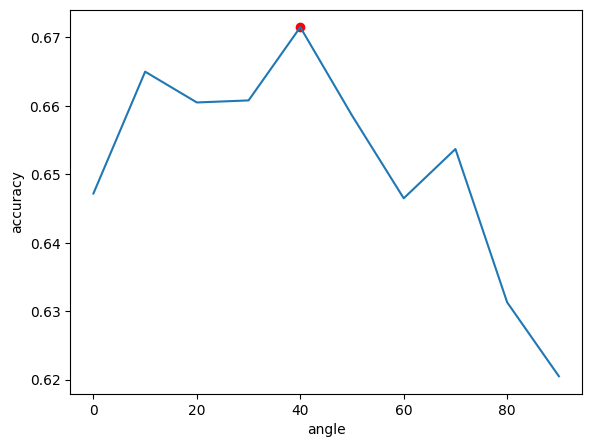

In [27]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angle_constraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angle_constraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [29]:
def shear(sample, amount):
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

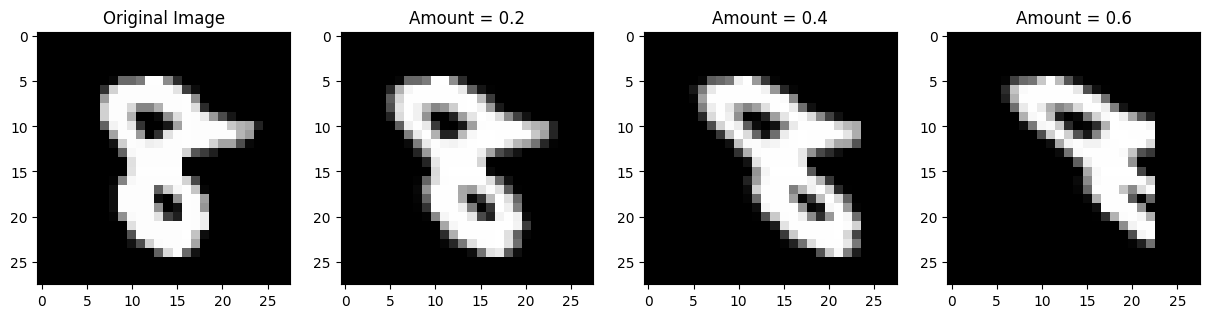

In [30]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [32]:
def aug_shear(sample, shearconstraint):
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))
    amt = (amt - 0.5) * shearconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)

Let us do a grid search to find the best shear constraint.

In [33]:
shear_constraints = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
accuracies = np.zeros(len(shear_constraints), dtype=float)

for ii in range(len(shear_constraints)):
    aug_data = train_X
    aug_target = train_y
    for jj in range(n_augmentations):
        aug_data = np.concatenate((aug_data, aug_shear(train_X, shear_constraints[ii])))
        aug_target = np.concatenate((aug_target, train_y))

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(aug_data.reshape(-1, 28*28), aug_target)
    test_pred = knn.predict(test_X.reshape(-1, 28*28))
    accuracies[ii] = accuracy_score(test_y, test_pred)
    print(f"Accuracy after shear augmentation constrained by {shear_constraints[ii]} is {accuracies[ii]*100:.2f}%")

Accuracy after shear augmentation constrained by 0 is 64.72%
Accuracy after shear augmentation constrained by 0.2 is 59.05%
Accuracy after shear augmentation constrained by 0.4 is 61.69%
Accuracy after shear augmentation constrained by 0.6 is 62.22%
Accuracy after shear augmentation constrained by 0.8 is 63.11%
Accuracy after shear augmentation constrained by 1.0 is 62.54%
Accuracy after shear augmentation constrained by 1.2 is 62.33%
Accuracy after shear augmentation constrained by 1.4 is 61.19%
Accuracy after shear augmentation constrained by 1.6 is 57.89%
Accuracy after shear augmentation constrained by 1.8 is 59.31%
Accuracy after shear augmentation constrained by 2.0 is 59.08%


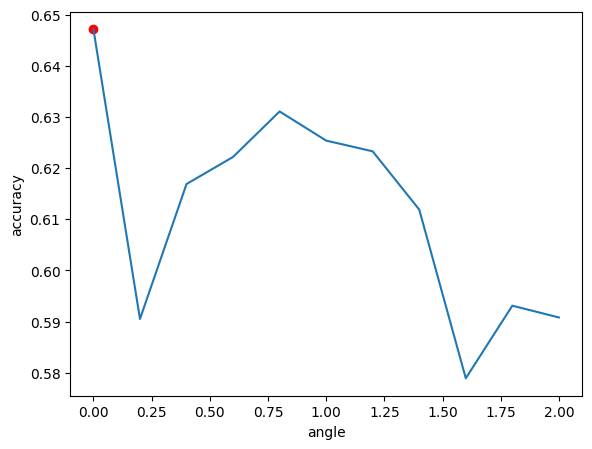

In [34]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(shear_constraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

maxind = np.argmax(accuracies)
plt.scatter(shear_constraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [36]:
def aug_rotate_shear(sample, angle_constraint, shear_constraint):
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))
    amt = (amt - 0.5) * shear_constraint
    angle = rng.random(len(sample))
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii])
    return np.squeeze(nsample)

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [38]:
shearconstraints = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]
angleconstraints = [0, 10, 20, 30, 40, 50, 60]
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)

for ii in range(len(hyp)):
    aug_data = train_X
    aug_target = train_y
    for jj in range(n_augmentations):
        aug_data = np.concatenate((aug_data, aug_rotate_shear(train_X, hyp[ii][0], hyp[ii][1])))
        aug_target = np.concatenate((aug_target, train_y))
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(aug_data.reshape(-1, 28*28), aug_target)
    test_pred = knn.predict(test_X.reshape(-1, 28*28))
    accuracies[ii] = accuracy_score(test_y, test_pred)
    print(f"Accuracy after augmentation shear: {hyp[ii][0]} angle: {hyp[ii][1]} is {accuracies[ii]*100:.2f}%")

Accuracy after augmentation shear: 0.0 angle: 0.0 is 59.22%
Accuracy after augmentation shear: 0.0 angle: 10.0 is 52.29%
Accuracy after augmentation shear: 0.0 angle: 20.0 is 52.12%
Accuracy after augmentation shear: 0.0 angle: 30.0 is 54.73%
Accuracy after augmentation shear: 0.0 angle: 40.0 is 56.58%
Accuracy after augmentation shear: 0.0 angle: 50.0 is 53.87%
Accuracy after augmentation shear: 0.0 angle: 60.0 is 53.42%
Accuracy after augmentation shear: 0.2 angle: 0.0 is 57.76%
Accuracy after augmentation shear: 0.2 angle: 10.0 is 52.18%
Accuracy after augmentation shear: 0.2 angle: 20.0 is 56.82%
Accuracy after augmentation shear: 0.2 angle: 30.0 is 55.27%
Accuracy after augmentation shear: 0.2 angle: 40.0 is 53.93%
Accuracy after augmentation shear: 0.2 angle: 50.0 is 56.67%
Accuracy after augmentation shear: 0.2 angle: 60.0 is 52.83%
Accuracy after augmentation shear: 0.4 angle: 0.0 is 58.02%
Accuracy after augmentation shear: 0.4 angle: 10.0 is 54.22%
Accuracy after augmentation

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

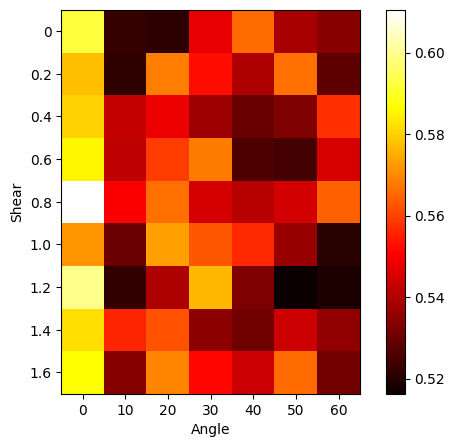

In [39]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.